In [12]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

In [13]:
data = pd.read_csv("/content/French_to_English.csv")

In [14]:
data

,French,English
0,new jersey est parfois calme pendant l' automne,new jersey is sometimes quiet during autumn
1,les états-unis est généralement froid en juillet,the united states is usually chilly during july
2,california est généralement calme en mars,california is usually quiet during march
3,les états-unis est parfois légère en juin,the united states is sometimes mild during june
4,votre moins aimé fruit est le raisin,your least liked fruit is the grape
...,...,...
137855,la france est jamais occupée en mars,france is never busy during march
137856,l' inde est parfois belle au printemps,india is sometimes beautiful during spring
137857,l' inde est jamais mouillé pendant l' été,india is never wet during summer
137858,la france est jamais froid en janvier,france is never chilly during january


In [15]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [16]:
data = read_text("/content/French_to_English.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [17]:
deu_eng

array([["new jersey est parfois calme pendant l' automne",
        'new jersey is sometimes quiet during autumn'],
       ['les états-unis est généralement froid en juillet ',
        'the united states is usually chilly during july '],
       ['california est généralement calme en mars ',
        'california is usually quiet during march '],
       ...,
       ["l' inde est jamais mouillé pendant l' été ",
        'india is never wet during summer '],
       ['la france est jamais froid en janvier ',
        'france is never chilly during january '],
       ["l'orange est son fruit préféré ",
        'the orange is her favorite fruit']], dtype='<U86')

In [18]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [19]:
deu_eng

array([['new jersey est parfois calme pendant l automne',
        'new jersey is sometimes quiet during autumn'],
       ['les étatsunis est généralement froid en juillet ',
        'the united states is usually chilly during july '],
       ['california est généralement calme en mars ',
        'california is usually quiet during march '],
       ...,
       ['l inde est jamais mouillé pendant l été ',
        'india is never wet during summer '],
       ['la france est jamais froid en janvier ',
        'france is never chilly during january '],
       ['lorange est son fruit préféré ',
        'the orange is her favorite fruit']], dtype='<U86')

In [20]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [21]:
deu_eng

array([['new jersey est parfois calme pendant l automne',
        'new jersey is sometimes quiet during autumn'],
       ['les étatsunis est généralement froid en juillet ',
        'the united states is usually chilly during july '],
       ['california est généralement calme en mars ',
        'california is usually quiet during march '],
       ...,
       ['l inde est jamais mouillé pendant l été ',
        'india is never wet during summer '],
       ['la france est jamais froid en janvier ',
        'france is never chilly during january '],
       ['lorange est son fruit préféré ',
        'the orange is her favorite fruit']], dtype='<U86')

In [22]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [23]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

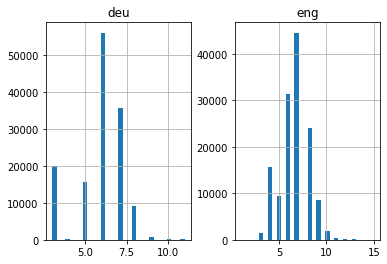

In [24]:
length_df.hist(bins = 30)
plt.show()

In [25]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [26]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 1])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 199


In [27]:
# prepare French tokenizer
deu_tokenizer = tokenization(deu_eng[:, 0])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('French Vocabulary Size: %d' % deu_vocab_size)

French Vocabulary Size: 334


In [28]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [29]:
# model building

from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 0])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 1])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 0])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 1])

# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model


In [30]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [31]:
filename = 'FR_to_Eng_model.h1.24_jun_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=25, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 88230 samples, validate on 22058 samples
Epoch 1/25
88230/88230 [==============================] - 25s 281us/step - loss: 1.9591 - val_loss: 1.0824

Epoch 00001: val_loss improved from inf to 1.08236, saving model to FR_to_Eng_model.h1.24_jun_20
Epoch 2/25
88230/88230 [==============================] - 22s 251us/step - loss: 0.8570 - val_loss: 0.6687

Epoch 00002: val_loss improved from 1.08236 to 0.66871, saving model to FR_to_Eng_model.h1.24_jun_20
Epoch 3/25
88230/88230 [==============================] - 22s 254us/step - loss: 0.5020 - val_loss: 0.3206

Epoch 00003: val_loss improved from 0.66871 to 0.32057, saving model to FR_to_Eng_model.h1.24_jun_20
Epoch 4/25
88230/88230 [==============================] - 22s 250us/step - loss: 0.2530 - val_loss: 0.1633

Epoch 00004: val_loss improved from 0.32057 to 0.16329, saving model to FR_to_Eng_model.h1.24_jun_20
Epoch 5/25
88230/88230 [==============================] - 22s 252us/step - loss: 0.1291 - val_loss: 0.1341

Epoch 0000

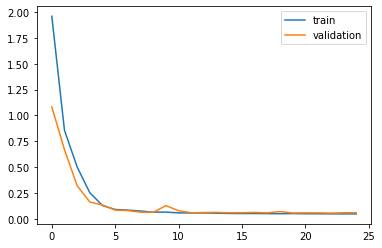

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [33]:
model = load_model('FR_to_Eng_model.h1.24_jun_20')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [34]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [35]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [36]:
pred_df = pd.DataFrame({'actual' : test[:,1], 'predicted' : preds_text})

In [37]:
pd.set_option('display.max_colwidth', 200)

In [38]:
pred_df.head(15)

,actual,predicted
0,your favorite fruit is the apple,your favorite fruit is the apple
1,france is never rainy during august,france is never rainy during august
2,the lime is her favorite fruit,the lime is her favorite fruit
3,he likes a big black automobile,he likes a big black automobile
4,california is busy during july,california is busy during july
5,new jersey is usually hot during march,new jersey is usually hot during march
6,they might go to paris next february,they might go to paris next february
7,our most loved fruit is the orange,our most loved fruit is the orange
8,he likes oranges,he likes oranges
9,india is usually mild during fall,india is usually mild during fall
